In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
# Custom made functions & classes (can be found in the Code directory)
from laser_dataset import FileReader, LaserDataInteractor

## Functions

In [21]:
"""
It does following:
    * Load the desired dataset
    * Compute the groudtruth segmentation (based on the Versuchstabelle and proper synchronization)
    * Plot all signals (ch1, ch2, ch3 and groundtruth)
    * Save the plot 
"""

def save_plots_single_trial(_interactor, trialNo, path_data, path_plots, fontsize=10):
    """
    The plot is saved as png, i.e. axis labels and titles should be scaled/modified in this function 
    (these settings cannot be changed in Latex once the plot is generated).
    
    Parameters
    ----------
        _interactor: data interactor class
            This should be instantiated prior to call this function 
        trialNo: str
            Trial number used to save the plots (e.g. '01_23')
        path_data: str
            Path to the raw data
        path_plots: str
            Path to the directory for saving the plot
    
    Comments
    --------
        * Saving plots as pgfplots coordinates (for Latex) failed due to the large number of data points 
          (thus data size, 1.5GB per channel)
        * Some settings should be adjusted and modified depending on the usage 
          (e.g. line width, font size for axis labels etc)
        * Higher resolution does not yield perceptible improvement in resolution, yet this can be also 
          increased/decreased 
        * Resulting data size (per channel) with the current setup = around 100KB 
    
    """
    #print('TrialNo.{}'.format(trialNo))
    
    # Params
    nfft = 2048
    l_seg = nfft # Length of each STFT segment
    l_overlap = int(l_seg/2) # 50% overlap
    fmin = 0 # [Hz]
    fmax = 750*10**3 # [Hz]
    fs = 6.25*10**6 # [Hz], same for all channels
    titles = ['SB1 (Ch.1)', 'SB2 (Ch.2)', 'AB (Ch.3)']
    
    # Specify the trialNo in the interactor class
    _interactor.df_row = trialNo

    # Iterate over the channels: Ch.1+2 = contact sensors, Ch.3 = air-couopled sensor
    for idx in range(3):
        
        # Channel number
        chNo = idx + 1
        # Load the raw data 
        sig = _interactor.load(chNo=chNo, path=path_data)
        
        # Instantiate
        fig, ax = plt.subplots(1, 1, sharex = False, sharey = False)
        # Figure size
        fig.set_figwidth(6.5)
        fig.set_figheight(4)

        # Spectrogram
        Pxx, freqs, bins, im = ax.specgram(
            sig, 
            NFFT=nfft, 
            Fs = fs, 
            noverlap = l_overlap, 
            mode='psd',
            cmap = 'rainbow', 
            vmax = 10, vmin = -140
        )

        # Limit the freq. range
        ax.set_ylim(fmin, fmax)
        # Ticks: y
        ax.set_yticks(np.array([0, 50, 250, 500, 750])* 10**3)
        ax.set_yticklabels(['0', '50k', '250k', '500k', '750k'], fontsize=fontsize)
        # Title
        ax.set_title(titles[idx], fontsize=fontsize)
        ax.grid(True)
        
        # Limit the time range, if the trial is the one with active welding (i.e. 1_X, 2_X, 3_X, CJ_X and TestschweißungX)
        if np.logical_or(trialNo.startswith('00_'), trialNo.startswith('LasHead')) == False:
            ax.set_xlim(0.0, 1.2)
            # Ticks: y
            ax.set_xticks(np.arange(0, 1.21, 0.2))
            
        # Color bar
        fig.colorbar(im, ax = ax)
    
        # Margins (add an offset to the figure)
        plt.margins(x = 0.0, y = 0.03)

        # (4) Save
        fname_plots = '{}/{}_ch{}.png'.format(path_plots, trialNo, chNo)
        # Parameters for savefig
        # dpi > 150 does not yield any perceptible difference in resolution 
        # bbox_inches: bounding box to determine the area to be saved => use 'tight', otherwise including a weird white space
        # pad_inches: margine to be padded, if bbox_inches == 'tight'
        plt.savefig(fname_plots, dpi = 150, bbox_inches = 'tight', pad_inches = 0.05) 

        # Close the figure
        plt.close()

        #plt.show()
        
    print('Saved!')
    
    

## Excel handling

In [3]:
# Load the Versuchsplan as a panda dataframe
path_meta = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/Versuchsplan_iHub.xlsx'
df = pd.read_excel(
    path_meta,
    sheet_name=1,
    usecols="B, D, F, G, I, J:L, Q:T",
    nrows=71,
    decimal=','
)
# Keep only the ones / rows for which the QASS data are available
df = df[df['QASS'].notna()]

In [4]:
df.keys()

Index(['Nr.', 'QASS', 'DEWETRON', 'Probe', 'Spalt [mm]', 'Crossjet', 'Umgeb.',
       'Einspannung', 'Tag', 'tstart [s]', 'tend [s]', 'Kommentar'],
      dtype='object')

In [5]:
np.array(df['DEWETRON'])

array(['01_0_1_Spalt_pneu', '02_0_1_Spalt_pneu', '03_0_1_Spalt_pneu',
       '04_0_1_Spalt_pneu', '05_0_1_Spalt_pneu', '06_0_1_Spalt_pneu',
       '07_0_1_Spalt_pneu', '08_0_1_Spalt_pneu', '09_0_1_Spalt_pneu',
       '10_0_1_Spalt_pneu', '11_0_2_Spalt_pneu', '12_0_2_Spalt_pneu',
       '13_0_2_Spalt_pneu', '14_0_2_Spalt_pneu', '15_0_2_Spalt_pneu',
       '16_0_2_Spalt_pneu', '17_0_2_Spalt_pneu', '18_0_3_Spalt_pneu',
       '19_0_3_Spalt_pneu', '20_0_3_Spalt_pneu', '21_0_3_Spalt_pneu',
       '22_0_3_Spalt_pneu', '23_0_2_Spalt_knie', '24_0_2_Spalt_knie',
       '25_0_2_Spalt_knie', '26_0_2_Spalt_knie', '27_0_1_Spalt_pneu',
       '28_0_1_Spalt_pneu', '29_0_1_Spalt_pneu', '30_0_2_Spalt_pneu',
       '31_0_2_Spalt_pneu', '32_0_2_Spalt_pneu', '33_0_3_Spalt_pneu',
       '34_0_3_Spalt_pneu', '35_0_3_Spalt_pneu',
       '36_0_2_Spalt_pneu_Stapler', '37_0_2_Spalt_pneu_Stapler',
       '38_0_2_Spalt_pneu_Flex', '39_0_2_Spalt_pneu_Flex',
       '40_0_2_Spalt_pneu_Hammer', '41_0_2_Spalt_pneu_Ham

### Grouping and sorting the dataframe
-> because otherwise 00_Refs are splitted and not sorted correctly. pands sort_values cannot be easily applied, as the numbers are stored as string, and 1_10 comes directly after 1_1 before 1_2. 

In [6]:
# Group 1: Labor vs Umgebungsrauschen
# term: grouper = boolean array to indicate which rows are relevant
grouper_lab = df['Umgeb.'].str.startswith('Labor')

df_noise = df[~grouper_lab].sort_values(by='Nr.')
df_noise.reset_index(drop=True, inplace=True)

In [7]:
# Group 2: special gap geometries 
grouper_gapincreasing = df['Probe'].str.startswith('Spalt aufsteigend')
df_gapincreasing = df[grouper_gapincreasing]
df_gapincreasing.reset_index(drop=True, inplace=True)

grouper_gapvar = df['Probe'].str.startswith('Spaltlänge var.')
df_gapvar = df[grouper_gapvar].sort_values(by='Nr.')
df_gapvar.reset_index(drop=True, inplace=True)

In [8]:
# Group 3: crossjet
grouper_cj = df['Crossjet'].str.startswith('X')
df_cj = df[grouper_cj].sort_values(by='Nr.')
df_cj.reset_index(drop=True, inplace=True)

In [9]:
# Group 4: standard gap with Kniehebelspanner
grouper_knie = df['Einspannung'].str.startswith('Knie')
df_knie = df[grouper_knie].sort_values(by='Nr.')
df_knie.reset_index(drop=True, inplace=True)

In [10]:
# Group 3: The standard one = rest: standard with pneumatic mounting => into 0.1mm, 0.2mm & 0.3mm
grouper_standard = ~(~grouper_lab + grouper_gapincreasing + grouper_gapvar + grouper_cj + grouper_knie)
df_standard = df[grouper_standard].sort_values(by='Nr.')

# gap = 0.1mm
grouper_01 = (df_standard['Spalt [mm]'].to_numpy() == 0.1)
df_01 = df_standard[grouper_01].sort_values(by='Nr.')
df_01.reset_index(drop=True, inplace=True)
# gap = 0.2mm
grouper_02 = (df_standard['Spalt [mm]'].to_numpy() == 0.2)
df_02 = df_standard[grouper_02].sort_values(by='Nr.')
df_02.reset_index(drop=True, inplace=True)
# # gap = 0.3mm
grouper_03 = (df_standard['Spalt [mm]'].to_numpy() == 0.3)
df_03 = df_standard[grouper_03].sort_values(by='Nr.')
df_03.reset_index(drop=True, inplace=True)

In [11]:
# Combine + replace the data frame
df = pd.concat([df_01, df_02, df_knie, df_noise, df_03, df_gapincreasing,  df_gapvar, df_cj], axis = 0).reset_index(drop=True)

In [12]:
np.array(df['DEWETRON'])

array(['01_0_1_Spalt_pneu', '02_0_1_Spalt_pneu', '03_0_1_Spalt_pneu',
       '04_0_1_Spalt_pneu', '05_0_1_Spalt_pneu', '06_0_1_Spalt_pneu',
       '07_0_1_Spalt_pneu', '08_0_1_Spalt_pneu', '09_0_1_Spalt_pneu',
       '10_0_1_Spalt_pneu', '27_0_1_Spalt_pneu', '28_0_1_Spalt_pneu',
       '29_0_1_Spalt_pneu', '11_0_2_Spalt_pneu', '12_0_2_Spalt_pneu',
       '13_0_2_Spalt_pneu', '14_0_2_Spalt_pneu', '15_0_2_Spalt_pneu',
       '16_0_2_Spalt_pneu', '17_0_2_Spalt_pneu', '30_0_2_Spalt_pneu',
       '31_0_2_Spalt_pneu', '32_0_2_Spalt_pneu', '23_0_2_Spalt_knie',
       '24_0_2_Spalt_knie', '25_0_2_Spalt_knie', '26_0_2_Spalt_knie',
       '36_0_2_Spalt_pneu_Stapler', '37_0_2_Spalt_pneu_Stapler',
       '38_0_2_Spalt_pneu_Flex', '39_0_2_Spalt_pneu_Flex',
       '40_0_2_Spalt_pneu_Hammer', '41_0_2_Spalt_pneu_Hammer',
       '18_0_3_Spalt_pneu', '19_0_3_Spalt_pneu', '20_0_3_Spalt_pneu',
       '21_0_3_Spalt_pneu', '22_0_3_Spalt_pneu', '33_0_3_Spalt_pneu',
       '34_0_3_Spalt_pneu', '35_0_3_Spalt_p

## Save the spectrograms

In [14]:
# Instantiate the interactor class
# -> no need to re-instantiate this class, if a new trial is to be loaded
interactor = LaserDataInteractor()
interactor.df = df

In [38]:
path_dataraw = '/Volumes/Sandisk_SD/Work/IZFP/Laser/05_2023_iHub/02_QASS'
path_png = '/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/catalog/figures/plots'

In [22]:
start = time.time()
offset = 0 # to skip the trials which are already saved
# Comment: For the trial "01_0_1_Spalt_pneu", Ch.2 signal is missing (not stored)

for idx, trialNo in enumerate(df['DEWETRON'][offset:offset+1]):
    start_iter = time.time()
    print(f'iter = {idx+offset}, trialNo = {trialNo}')
    save_plots_single_trial(interactor, trialNo, path_dataraw, path_png)
    
    print(f'execution time = {round(time.time()-start_iter, 3)}s')
    print('#==================#')

end = time.time()
print(f'Complete = {round((end - start)/60, 3)}min')

iter = 0, trialNo = 01_0_1_Spalt_pneu
Saved!
execution time = 6.921s
#==================#
Complete = 0.115min


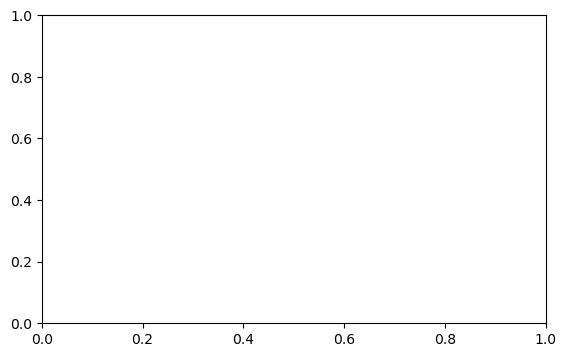

In [39]:
# Save a dummy plot for 01_0_1_Spalt_pneu_ch2 (becuase the data do not exist)

# Instantiate
fig, ax = plt.subplots(1, 1, sharex = False, sharey = False)
# Figure size
fig.set_figwidth(6.5)
fig.set_figheight(4)

plt.savefig(f'{path_png}/01_0_1_Spalt_pneu_ch2.png', dpi = 150, bbox_inches = 'tight', pad_inches = 0.05) 

plt.show()

In [17]:
import sys
sys.exit()

SystemExit: 

/Users/sayakokodera/miniforge3/envs/insigna/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Generate the tex files

In [35]:
"""
Example tex file for each page using the command visualizesingletrial:
    
    % left = 0_1
    \subsection*{ Trial 0\textunderscore1, Gap = kein Spalt with nan mm }
    Nur Roboter ohne Absaugung
    \begin{figure}[h!]
    \visualizesingletrial{figures/plots/0_1_ch1.png}{figures/plots/0_1_ch2.png}{figures/plots/0_1_ch3.png}{figures/plots/0_1_ch4.png}
    \end{figure}
    %
    % right = 0_2
    \subsection*{ Trial 0\textunderscore2, Gap = kein Spalt with nan mm }
    Nur Roboter mit Absaugung
    \begin{figure}[h!]
    \visualizesingletrial{figures/plots/0_2_ch1.png}{figures/plots/0_2_ch2.png}{figures/plots/0_2_ch3.png}{figures/plots/0_2_ch4.png}
    \end{figure}
    \clearpage
"""

def format_trialNo(trialNo):
    """
    Correct formatting of the trial number, s.t. it can be shown proeprly after compilining with latex
    (e.g.) 19_0_3_Spalt_pneu -> 19{\\_}0{\\_}3{\\_}Spalt{\\_}pneu
    Comment: {\\_} will be shown as {\_} in latex
    """
    name = trialNo.replace('_', r"""{\_}""")
    return name


def tex_text_single_trial(trialNo):
    # Check whether trialNo is a proper one or None (= we need to insert \newpage here)
    if trialNo is None:
        text = "%"
    
    else:
        # For each trial, we include: (1) section title = trialNo & gap type and size, (2)Bemerkung, (3)spectrogram
        # (1) section title
        gapsize = df['Spalt [mm]'][df['DEWETRON'] == trialNo].values[0]
        day = int(df['Tag'][df['DEWETRON'] == trialNo].values[0])
        trialNo_formatted = format_trialNo(trialNo)
        title = f'{trialNo_formatted}, Gap = {gapsize} mm, Day {day}' 
        # (2) Bemerkung
        comment = df['Kommentar'][df['DEWETRON'] == trialNo].values[0]
        # In case there are underbars in the comment -> replace (if not, it just igrnoes the command)
        if type(comment) == str:
            comment = comment.replace('_', r"""{\_}""")

        # Full text 
        text = (r"""\subsection*{{ {} }}""".format(title) +
                '\n' +
                f'{comment}' +
                '\n' +
                r"""\begin{figure}[h!]""" + '\n' +
                r"""\visualizesingletrial{{figures/plots/{}_ch1.png}}""".format(trialNo) + 
                r"""{{figures/plots/{}_ch2.png}}""".format(trialNo) + 
                r"""{{figures/plots/{}_ch3.png}}""".format(trialNo) + 
                '\n' +
                r"""\end{figure}"""
                )
    return text
    

def tex_files_single_page(trial_top, trial_bottom, path_tex, scenarioNo, pageNo):
    """
    Parameters
    ----------
        trial_top: str
            Trial No. of the top figure
        trial_bottom: str
            Trial No. of the bottom figure
    """
    print(f'*** New page!: top = {trial_top}, bottom = {trial_bottom}')
    
    text_top = tex_text_single_trial(trial_top)
    text_bottom = tex_text_single_trial(trial_bottom)

    # Generate a tex file
    text = (f'% left = {trial_top}' + '\n' +
            text_top + '\n' +
            '%' + '\n' + 
            f'% right = {trial_bottom}' + '\n' +
            text_bottom + '\n' +
            r"""\clearpage""")

    # Save
    
    fname = f'{path_tex}/figures/scenario_{scenarioNo}_page_{pageNo}.tex'
    f = open(fname, 'w')
    f.write(text)
    f.close() 

    print(f'Scenario {scenarioNo}, page {pageNo}: data saved! as')
    print(fname)
    print('+==================================+')

    
def tex_files_single_scenario(scenarioNo, row_start, row_end):
    """
    Parameters
    ----------
        scenarioNo: int
            0 = reference weld
            1 = gap 0.1 mm
            2 = gap 0.2 mm
            3 = gap 0.3mm
            4 = CJ
        row_start: int
            Row number where the desired scenario starts
        row_end: int
            Row number where the NEXT (!!!!) scenario starts
            -> this row will NOT be included in the desired scenario
            
    Remarks
    -------
        There are two cases:
            (a) Number of the trials in the desired scenario == even
                -> nothing special needs to be done, just iterate and place the plots
            (b) Number of the trials in the desired scenario == odd
                -> the last page contains only ONE plot
                -> trial_right should be None! 
    """
    # Initialize
    pageNo = 1
    # Trials which need to be placed in the top
    tops = np.array(df['DEWETRON'])[row_start:row_end:2]
    # Trials which need to be placed in the bottom -> see remarks
    if (row_end - row_start)%2 == 0:
        bottoms = np.array(df['DEWETRON'])[row_start+1:row_end:2]
    else:
        bottoms = np.array(df['DEWETRON'])[row_start+1:row_end-1:2]
        bottoms = np.concatenate((bottoms, [None]))
    
    
    # Iterate over every 2(!!!) trials
    for (trial_top, trial_bottom) in zip(tops, bottoms):
        # Generate the tex file
        tex_files_single_page(trial_top, trial_bottom, path_tex, scenarioNo, pageNo)
        # Update
        pageNo += 1
    

In [20]:
path_tex = '/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/test'

tex_files_single_page(df['DEWETRON'][0], df['DEWETRON'][1], path_tex, 0, 1)
tex_files_single_page(df['DEWETRON'][0], None, path_tex, 0, 2)

*** New page!: top = 01_0_1_Spalt_pneu, bottom = 02_0_1_Spalt_pneu
Scenario 0, page 1: data saved! as
/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/test/figures/scenario_0_page_1.tex
+==================================+
*** New page!: top = 01_0_1_Spalt_pneu, bottom = None
Scenario 0, page 2: data saved! as
/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/test/figures/scenario_0_page_2.tex
+==================================+


In [22]:
df_01['DEWETRON'][0]

'01_0_1_Spalt_pneu'

In [36]:
path_tex = '/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/catalog'

# List of the start of each scenarios
breakpoints = [
    df_01['DEWETRON'][0], # -> scenario 1
    df_02['DEWETRON'][0], # -> scenario 2
    #df_knie['DEWETRON'][0], # -> scenario 2 
    #df_noise['DEWETRON'][0], # -> scenario 2
    df_03['DEWETRON'][0], # -> scenario 3
    df_gapincreasing['DEWETRON'][0], # scenario 4
    df_gapvar['DEWETRON'][0], # scenario 5
    df_cj['DEWETRON'][0], # scenario 6
    'Dummy_End'
]

# Initialize
scenarioNo = 1

# Iterate over the breakpoints
for bp_start, bp_end in zip(breakpoints[0:-1:], breakpoints[1::]):
    # (1) Identify the rows
    row_start = list(df['DEWETRON']).index(bp_start)
    if bp_end == 'Dummy_End':
        row_end = len(df) + 1
    else:
        row_end = list(df['DEWETRON']).index(bp_end)
        
    # (2) Generate the tex files
    tex_files_single_scenario(scenarioNo, row_start, row_end)
    # Update
    scenarioNo += 1
    
    

*** New page!: top = 01_0_1_Spalt_pneu, bottom = 02_0_1_Spalt_pneu
Scenario 1, page 1: data saved! as
/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/catalog/figures/scenario_1_page_1.tex
+==================================+
*** New page!: top = 03_0_1_Spalt_pneu, bottom = 04_0_1_Spalt_pneu
Scenario 1, page 2: data saved! as
/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/catalog/figures/scenario_1_page_2.tex
+==================================+
*** New page!: top = 05_0_1_Spalt_pneu, bottom = 06_0_1_Spalt_pneu
Scenario 1, page 3: data saved! as
/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/catalog/figures/scenario_1_page_3.tex
+==================================+
*** New page!: top = 07_0_1_Spalt_pneu, bottom = 08_0_1_Spalt_pneu
Scenario 1, page 4: data saved! as
/Users/sayakokodera/Work/IZFP/Laser/03_2023_iHub/Tex/catalog/figures/scenario_1_page_4.tex
+==================================+
*** New page!: top = 09_0_1_Spalt_pneu, bottom = 10_0_1_Spalt_pneu
Scenario 1, p